### Real-Data Benchmarking

This notebook goes over a collection of estimators used to model trend (change in mean) across a time series. Specifically a focus is on trend filtering and it's performance in estimation and computation time against splines, kernels, and segmented regression

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")


PATH = "../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)
DATA_FILE = "AMZN_reconstructed_features.csv"


In [2]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0, nrows=15000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]



### Screening by sale condtion of trades

- Examining only regular trades allows for a much better performace in terms of efficiency and estimation



In [3]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,YearMonth,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
trade_data["Sale_Condition"].unique()

array(['@  I', '@F I', '@  Q', '@ TI', '@O X', '@   ', '@F  ', '@4 I',
       '@4 W', '@ ZI', 'R  W'], dtype=object)

### Visualizing Market Data

Plotted below is AMZN trade price and volume data 

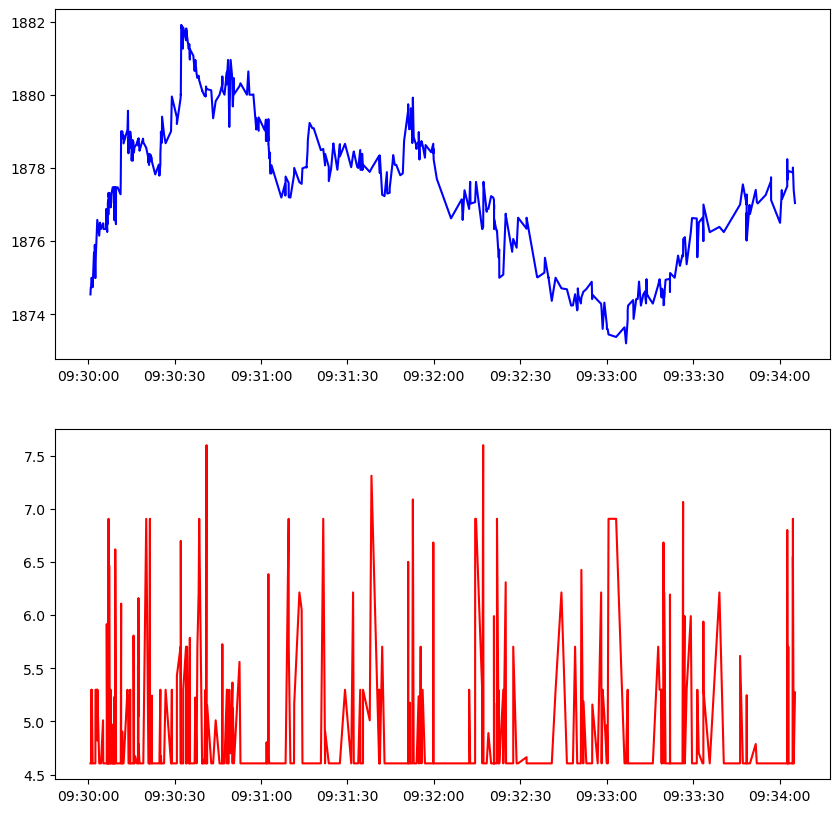

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

trade_price=regular_trades["Trade_Price"]
trade_volume=regular_trades["Trade_Volume"]


ax[0].plot(trade_price, label="Trade Price",color='blue')

ax[1].plot(np.log(trade_volume), label="Log Trade Volume",color='red')



plt.show()



### Quick Performance of Trend Filtering

In [6]:
from matrix_algorithms.difference_matrix import Difference_Matrix
from trend_filtering.cv_tf import cross_validation
from trend_filtering.adaptive_tf import adaptive_tf

In [7]:
trade_price=trade_price.values

D=Difference_Matrix(len(trade_price),k=1)
best_lambda=cross_validation(trade_price.reshape(-1,1), D,cv_folds=15,cv_iterations=3,verbose=True)

print(f"Best lambda: {best_lambda}")



Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 3.298426967456393
Performing cross validation for lambda = 6.3682654549553215
Performing cross validation for lambda = 12.295195650807893
Performing cross validation for lambda = 23.738306319190034
Performing cross validation for lambda = 45.83149409799508
Performing cross validation for lambda = 88.48676156632517
Performing cross validation for lambda = 170.8411895923378
Performing cross validation for lambda = 329.8426967456393
Performing cross validation for lambda = 636.8265454955322
Performing cross validation for lambda = 1229.5195650807893
Performing cross validation for lambda = 2373.8306319190006
Performing cross validation for lambda = 4583.149409799509
Performing cross validation for lambda = 8848.676156632519
Performing cross validation for lambda = 17084.118959233765
Performing cross validation for lambda = 32984.269674563926
No solution found for lambda = 32984.269674563926
Stat

In [8]:
results=adaptive_tf(trade_price.reshape(-1,1), D, best_lambda ,select_knots=True)

{1: [238], 2: [238, 578], 3: [238, 446, 578], 4: [238, 362, 446, 578], 5: [91, 238, 362, 446, 578], 0: []}


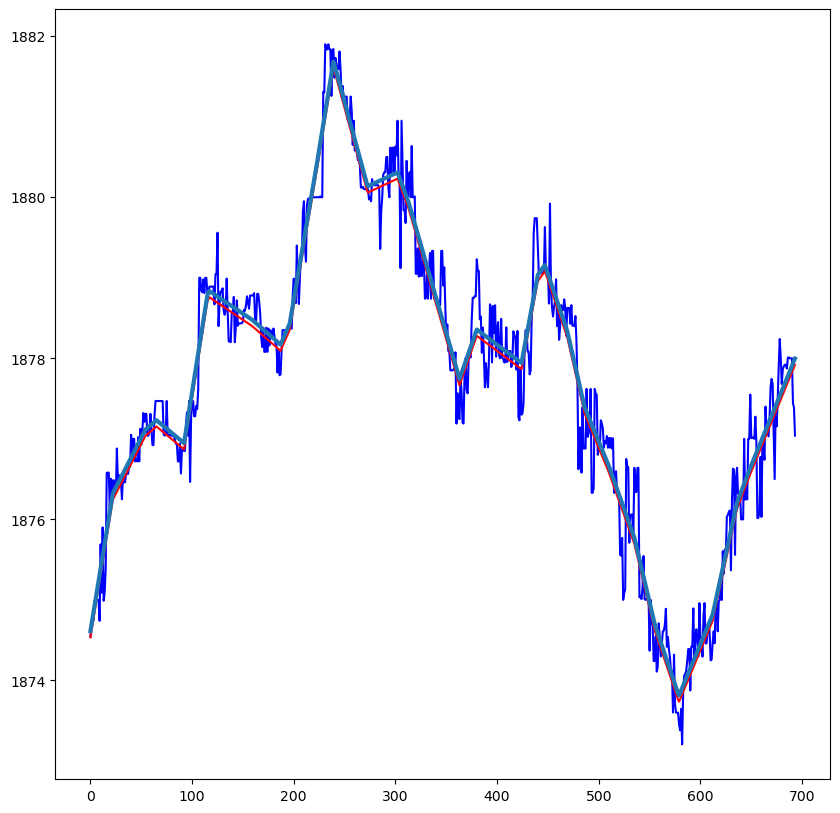

In [9]:
results["sol"].predict(np.arange(len(trade_price)))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="Trade Price",color='blue')
ax.plot(results["sol"].predict(np.arange(len(trade_price))), label="Predicted Price",color='red')
ax.plot(results["sol"].x, label="Estimate",lw=3)



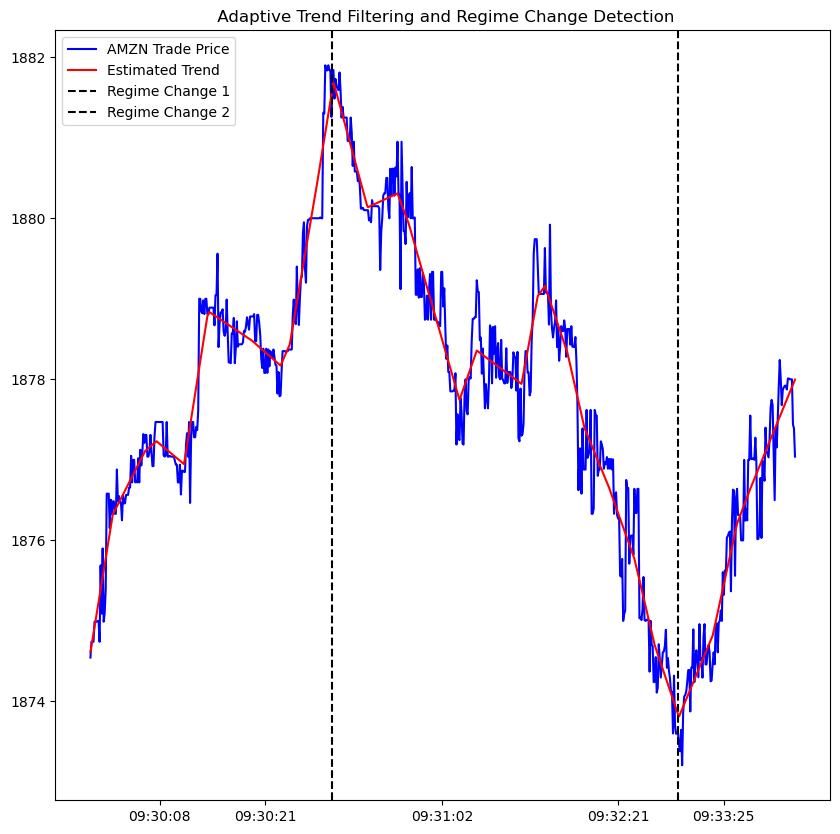

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(results["sol"].x, label="Estimated Trend ",color='red')

for i in range(len(results["sol"].knots)):
    ax.axvline(results["sol"].knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

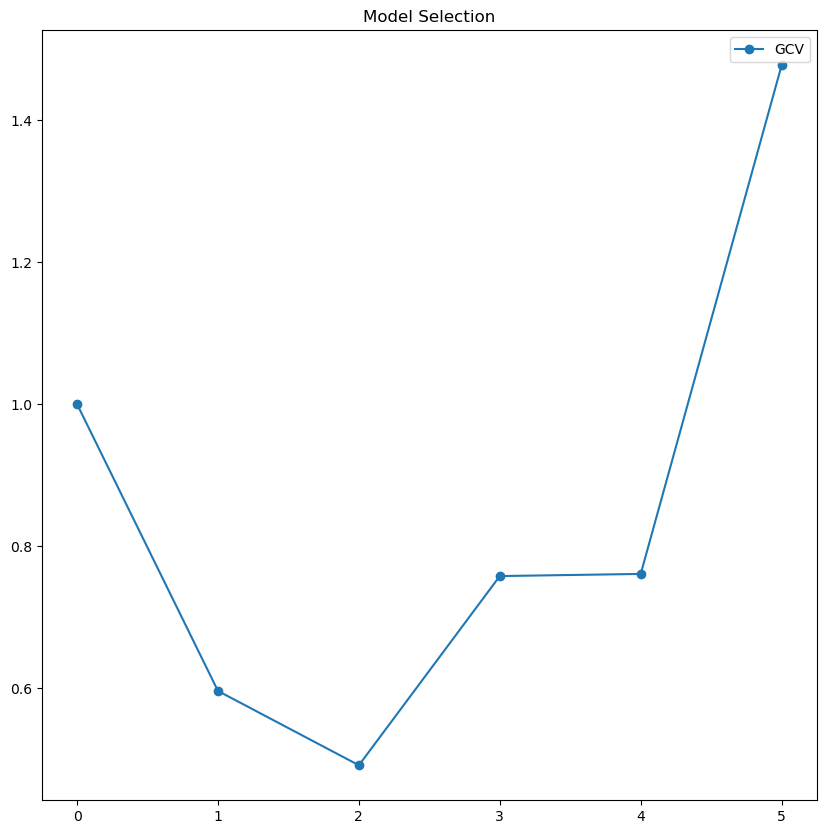

In [11]:
sorted_gcvs=sorted(results['sol'].gcv_scores, key=lambda x: x[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Model Selection")
ax.plot([i[0] for i in sorted_gcvs], [i[1] for i in sorted_gcvs], label="GCV",marker='o')
ax.legend()
    